# Exercise - Gradient Descent 

In this exercise, we will be implementing linear regression, using Gradient Descent algorithm with Bold Driver, in Python. 

Objectives of this exercise are: 
* Understanding Gradient Descent algorithm and being able to implement that with Python. 
* Being able to use Numpy operations for feature standardization, efficient computation of gradient and loss function.

This exercise does not focus on improving the model for better prediction performance.  

## Data

In this exercise, we will use two datasets for fitting linear regression model. One is a 1D (1 feature) synthetic linear data , which can get visualized to see the fitted line. The other is a multi-dimensional data, with 58 features, about online news popularity, obtained from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Dataset 1 - 1D synthetic linear data

In the following code, we generate a set of data points along a line.

In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [2]:
np.random.seed(553)

# here's a function that generates linear data
def genLinearData(x, slope, intercept):
    return slope * x + intercept

# and here's a function that adds Gaussian noise to a set of values
def addGaussianNoise(data, mu, sigma):
    ''' 
    data is the data to add noise to
    mu is the median of the Gaussian
    sigma is the standard deviation of the Gaussian
    '''
    return data + np.random.normal(mu, sigma, len(data))

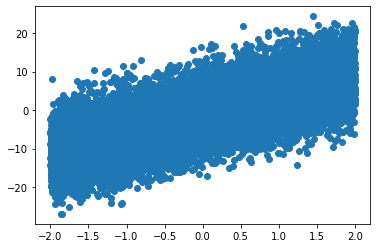

In [3]:
# generate a dataset for linear regression
numPoints = 20000 # number of points

# evenly spaced x values
X_synthetic = np.linspace(-2,2,numPoints)

# "true" y values, based on the slope, intercept, and x values
true_y = genLinearData(X_synthetic, slope=5, intercept=-1)

# add noise, mu = 0, sigma = 5
y_synthetic = addGaussianNoise(true_y, 0, 5)

# plot the data points
plt.scatter(X_synthetic, y_synthetic)

### Dataset 2 - Online news popularity dataset

The source of this dataset is UCI Machine Learning Repository. In the `data` directory of your workspace, you can find the whole dataset in a `csv` file, `OnlineNewsPopularity.csv`. It contains 58 features extracted from 39644 online news articles and a target attribute `shares` that indicates the popularity of the news articles with number of times they have been shared. You can find the description of attributes [here](https://archive.ics.uci.edu/ml/datasets/online+news+popularity). We already removed the two non-predictive attributes (url and timedelta) from the dataset, as well as the header to be able to read this dataset into a Numpy array (all features and target are numeric).  

In the following code, we read the `csv` file into 2D Numpy array. Then, we put all the features into a 2D Numpy array, and the target attribute into a 1D numpy array.  

In [39]:
news_data = np.loadtxt('data/OnlineNewsPopularity.csv', delimiter=',')

In [40]:
# feature vectors
X_news = news_data[:, :-1]
print("Shape of feature array of the online news dataset:\n", X_news.shape)
# target attribute
y_news = news_data[:,-1]

Shape of feature array of the online news dataset:
 (39644, 58)


## Task 1 - Standardization (10 pts)

Your first task is to complete the function `standardize()` below that gets a 2D numpy array (columns correspond to features) and returns a standardized array. You need to standardize the features (columns of the input 2D array) such that each feature would have zero mean and standard deviation of 1. This method generally improves the performance of machine learning algorithms when features are very different in range. Features with very large values can dominate over other features with lower values. Standardization makes the range of features to be close to each other. 

The general method of calculation is to determine the mean and standard deviation of each feature. Then, subtract the mean from each feature, and divide the result by the standard deviation.

$$\frac{x-\hat{x}}{\sigma}$$

**Important Note:** This exercise aims at enhancing your Numpy skills to do efficient mathematical computations. Therefore, it is expected that you don't use any loop in your code for this task, and use Numpy array operations to do computations, such as `np.mean()` and `np.std()`.   

In [41]:
def standardize (X):
    """
    X is a 2D Numpy array that each row is a feature vector of a data point (columns are features)
    Returns a standardized 2D Numpy array 
    """
    # Enter your code here
    std = np.std(X, 0)
    mean = np.mean(X, 0)
    #return (X-mean)/std, (X[0]-mean)/std, (X[1]-mean)/std
    #return X-mean, X[0]-mean, X[1]-mean
    #return len(std), len(mean)
    return np.divide(X-mean, std)

Run the code cell below to standardize online news dataset. We don't need to standardize our synthetic 1D data since it only conrains 1 feature. 

In [52]:
X_news_standard = standardize (X_news)
print(X_news_standard)

[[ 0.75744723 -0.69521045  0.03277187 ... -0.97543219 -1.81071884
   0.13891975]
 [-0.66165665 -0.61879381  0.01605588 ... -0.26907618  0.83774863
  -0.68965812]
 [-0.66165665 -0.71219192  0.00764453 ... -0.26907618  0.83774863
  -0.68965812]
 ...
 [-0.18862202 -0.2218518  -0.00904959 ...  0.24463728 -1.56994907
  -0.08705603]
 [-2.08076053  0.28759248 -0.00247749 ... -0.26907618  0.83774863
  -0.68965812]
 [-0.18862202 -0.82681689  0.04367671 ...  0.67273184 -0.92789635
   0.41511238]]


## Task 2 - Adding intercept (5 pts)

Your second task is to complete the function `add_intercept()` below that gets a 2D numpy array (columns correspond to features) and adds a column with the constant `1` at the end of the array, and returns this new array. 

**Important Note:** This exercise aims at enhancing your Numpy skills to do efficient mathematical computations. Therefore, it is expected that you don't use any loop in your code for this task, and use Numpy array operations to do computations. 

In [43]:
def add_intercept (X):
    """
    X is a 2D Numpy array that each row is a feature vector of a data point (columns are features)
    Returns a 2D Numpy array same as the input with one additional column at the end with values 1 
    """
    # Enter your code here 
    col_len = X.shape[0]
    new_col = np.ones((col_len, 1))
    
    return np.hstack((X, new_col))


Run the code cells below to add intercept to both datasets. 

In [44]:
X_synthetic_features = add_intercept(X_synthetic.reshape(X_synthetic.shape[0],-1))
print(X_synthetic_features.shape)

(20000, 2)


In [45]:
X_news_features = add_intercept(X_news_standard)
print(X_news_features.shape)

(39644, 59)


## Task 3 - Gradient Descent with Bold Driver for Linear Regression (35 pts)

Your third task is to complete the function `lr_gd_bd()` below that gets
* `X` - a 2D Numpy array (columns correspond to features)
* `y` - a 1D Numpy array that corresponds to the target attribute having observed values
* `theta_init` - a 1D Numpy array that corresponds to the initial guess for parameters (coefficients)
* `numIters` - maximum number of iterations to run
* `eps` - change in parameters from iteration to iteration. Stopping condition
* `lRate` - learning rate


and returns
* the number of iterations actually run
* the optimum parameters obtained from Gradient Descent 
* the final loss value (mean squared error) from the last iteration 

In this function you need to implement Gradient Descent algorithm with Bold Driver for linear regression model. 

Recall the pseudocode in the lecture:

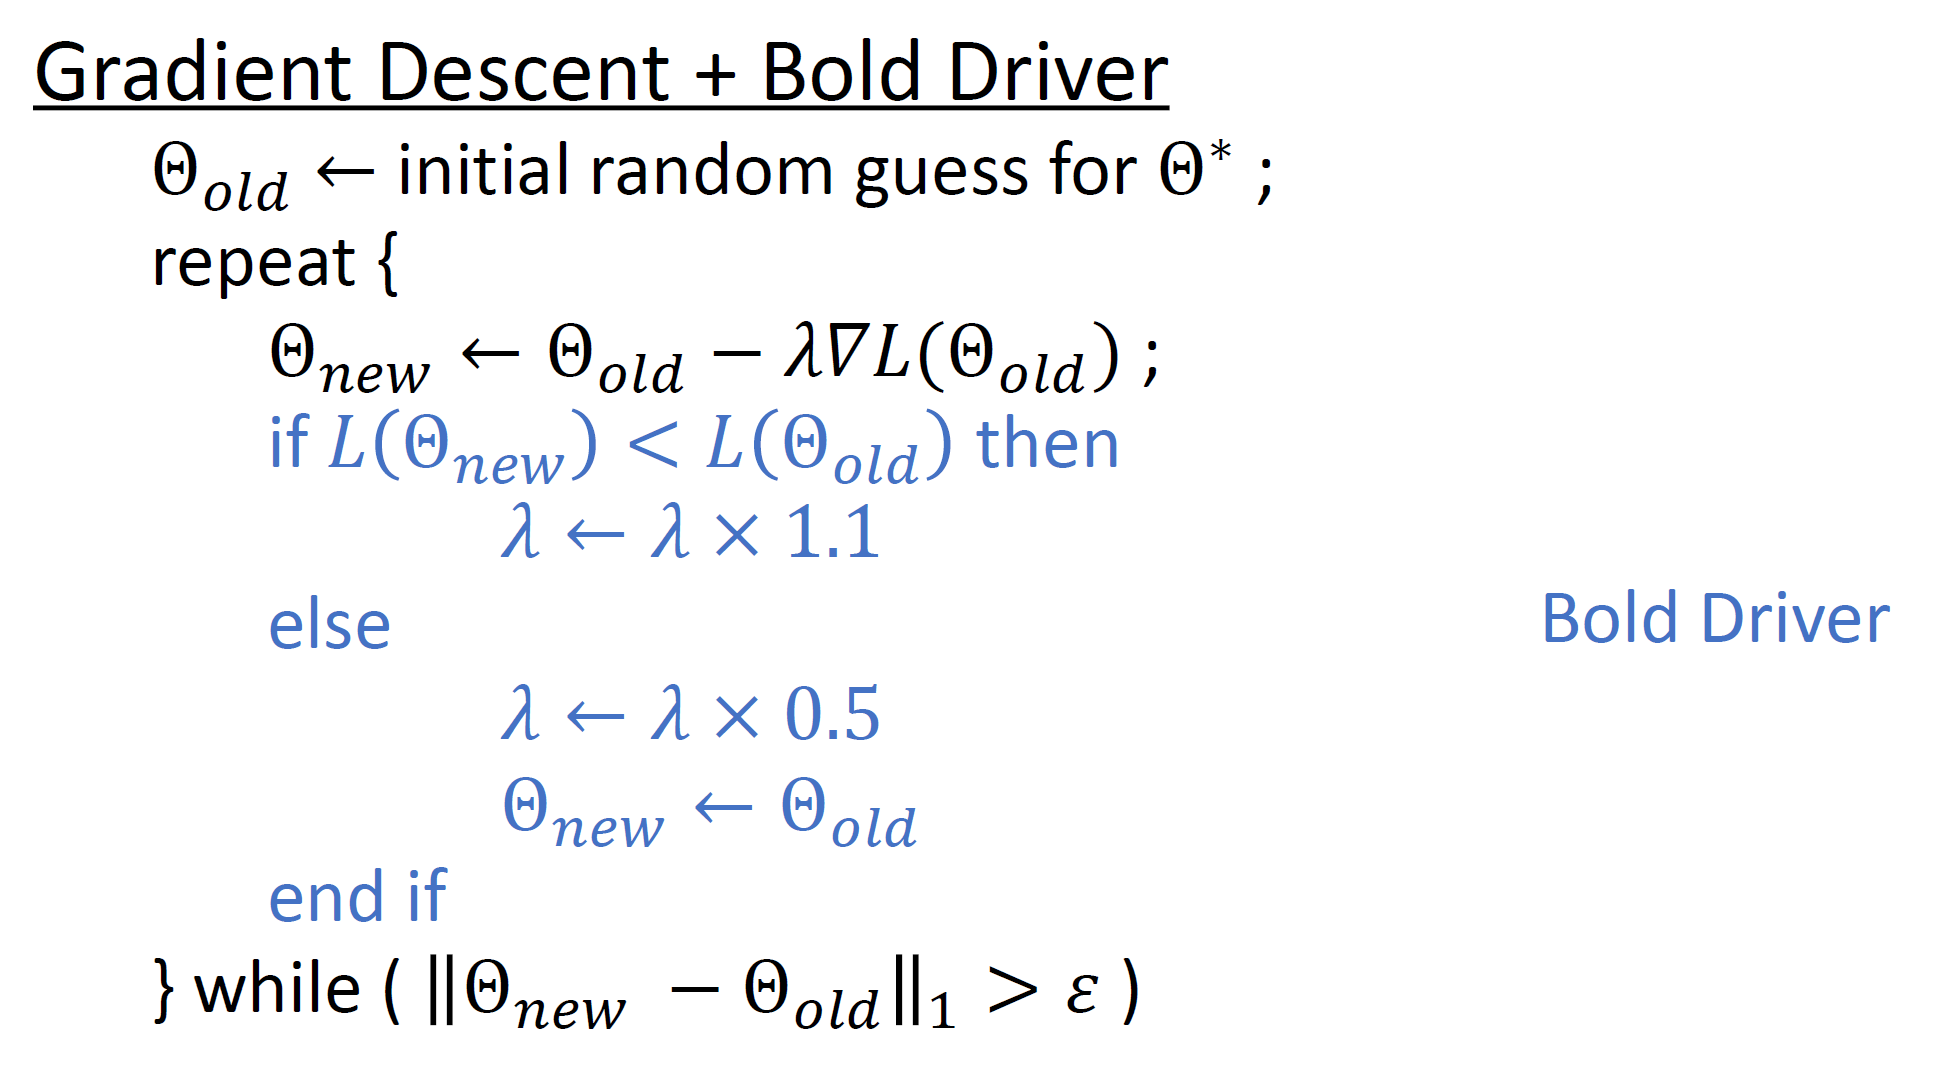


For loss function, use mean squared error. 

Your function should run for a specified number of iterations (numIters) OR until the total change in parameters (L1-norm) from one iteration to the next is less than or equal to an epsilon value (eps).

To implement this pseudocode in Python, you can follow the template below:  
```
while True:
    theta_new = theta_old - lambda * grad(L)
    if (L1-norm(theta_new, theta_old)<=eps) or (number of iterations>numIters):
        break
    Implement Bold Driver ...
    # set theta_new to theta_old to be used for next iteration 
    theta_old = theta_new
    
```

**Gradient formula for m-D features**

In the lecture, we showed the formula for the gradient of mean squared error loss function for a simple model of $ \hat{y} = mx+b $. 

In this exercise, we want to generalize this to m-D features (like in our online news dataset) for the general model of  
$$ \hat{y} = X.\theta = \sum_{j=1}^{m} x_j \theta_j $$

For this model, mean squared error loss function is:
$$ L = \frac{\sum_{i=1}^{n}(y^\left(i\right) - \hat{y}^\left(i\right) )^2}{n} = \frac{\sum_{i=1}^{n}(y^\left(i\right) - X^\left(i\right).\theta )^2}{n} = \frac{\sum_{i=1}^{n}(y^\left(i\right) - \sum_{j=1}^{m} x_j^\left(i\right) \theta_j )^2}{n} $$ 



And the gradient of this loss function is:
$$ \nabla{L} = <\frac{\partial L}{\partial \theta_1}, \frac{\partial L}{\partial \theta_2}, ..., \frac{\partial L}{\partial \theta_m}>  $$

$$ \frac{\partial L}{\partial \theta_j} = \frac{-2}{n}\sum_{i=1}^{n} x_j^\left(i\right) (y^\left(i\right) - \hat{y}^\left(i\right) ) $$


**Important Note:** This exercise aims at enhancing your Numpy skills to do efficient mathematical computations. Therefore, it is expected that you only use 1 loop for the Gradient Descent loop and you don't use any loop in your gradient or loss computations. For those computations use Numpy array operations such as `np.dot()` and `np.sum()`. 

In [67]:
def lr_gd_bd (X, y, theta_init, numIters, eps, lRate):
    """
    Gradient Descent algorithm with Bold Driver for linear regression using mean squared error. 
    
    Returns
        the number of iterations actually run
        the optimum parameters obtained from Gradient Descent 
        the final loss value (mean squared error) from the last iteration

    Parameters:
        X - a 2D Numpy array (columns correspond to features)
        y - a 1D Numpy array that corresponds to the target attribute having observed values
        theta_init - a 1D Numpy array that corresponds to the initial guess for parameters (coefficients)
        numIters - maximum number of iterations to run
        eps - change in parameters from iteration to iteration. Stopping condition
        lRate - learning rate
    """
    # Enter your code here 
    n = len(y)
    theta_old = theta_init
    i = 0
    loss_old = np.sum(np.square(np.dot(X, theta_old) - y))/n
    while True:
        theta_new = theta_old - lRate * np.dot(X.T, np.dot(X, theta_old)-y)
        loss_new = np.sum(np.square(np.dot(X, theta_new) - y))/n
        i+=1
        if  abs(loss_new-loss_old) < eps or i == numIters:
            break
        if loss_new < loss_old:
            lRate *= 1.1
        else:
            lRate *= .5
            theta_new = theta_old
            continue
        loss_old = loss_new
        theta_old = theta_new
        
    return i, theta_old, loss_old

Run the code cells below to find optimum parameters on both datasets. 

First, let's run on the synthetic 1D data.

Since we generated the synthetic linear data, with slope=5 and intercept=-1, we expect the optimum parameters obtained by the Gradient Descent algorithms to be close to these values. 

In [68]:
np.random.seed(10)
synthetic_theta_init = np.random.random_sample(X_synthetic_features.shape[1])
synthetic_num_its, synthetic_optimum_params, synthetic_final_loss = lr_gd_bd (X_synthetic_features, y_synthetic, synthetic_theta_init, 100, 0.01, 0.1)
#print(y_synthetic.shape, synthetic_theta_init)

In [69]:
print('----- Gradient Descent result on 1D synthetic linear data -----')
print('Number of iterations = ', synthetic_num_its)
print('Optimum slope = ', synthetic_optimum_params[0])
print('Optimum intercept = ', synthetic_optimum_params[1])
print('Final loss = ', synthetic_final_loss)

----- Gradient Descent result on 1D synthetic linear data -----
Number of iterations =  19
Optimum slope =  4.976994522935198
Optimum intercept =  -1.01718427580568
Final loss =  25.23958587415245


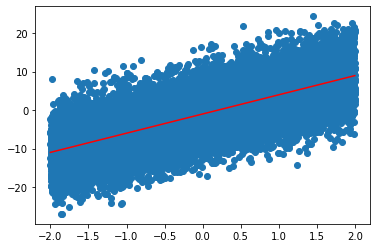

In [70]:
# visualize the fitted line
plt.scatter(X_synthetic,y_synthetic)
# show the fitted line with the optimum slope and intercept
y_predict = synthetic_optimum_params[0] * X_synthetic + synthetic_optimum_params[1]
plt.plot(X_synthetic, y_predict, 'r')

Now, let's run it on the online news popularity dataset.

In [71]:
np.random.seed(10)
news_theta_init = np.random.random_sample(X_news_features.shape[1])
news_num_its, news_optimum_params, news_final_loss = lr_gd_bd (X_news_features, y_news, news_theta_init, 10000, 0.5, 0.1)

In [72]:
print('----- Gradient Descent result on online news popularity dataset -----')
print('Number of iterations = ', news_num_its)
print('Optimum parameters = \n', news_optimum_params)
print('Final loss = ', news_final_loss)

----- Gradient Descent result on online news popularity dataset -----
Number of iterations =  329
Optimum parameters = 
 [ 1.88777012e+02  1.24969940e+02  1.16891144e+02 -1.64290515e+02
  7.83816087e+01  3.07094615e+02 -2.17330318e+02  9.45802187e+01
  3.82020812e+01 -3.93159286e+02  9.52092670e+01 -2.48395417e+02
 -4.65239956e+02 -3.14210240e+02 -1.51727840e+02 -2.38667912e+02
 -2.26437417e+02  1.56924715e+02  3.28621932e+02 -2.08720236e+02
 -1.21897180e+02 -1.18309270e+02 -8.28807731e+01 -4.12293185e+02
 -1.22552843e+03  2.17923779e+03  5.12559767e+02  2.31929327e+02
 -1.32546224e+02  1.39625076e+02 -6.41750628e+01 -3.52266142e-01
 -6.82887766e+01 -4.78738247e+01  8.12571642e+01 -8.39016080e+00
  5.15570919e+01  1.47751092e+02 -4.79957391e+01 -1.95889004e+02
  6.20400309e+01  3.57545734e+01  2.93856131e+02  5.09683247e+01
 -1.96449004e+02  3.22819673e+01  2.47250000e+02  1.80724320e+02
 -1.49627327e+02 -1.05689251e+02  4.28756734e+01 -2.12204726e+02
  6.77668358e+01 -4.61573312e+01 -